In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import cv2
import torch
import random
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import matplotlib.pyplot as plt
import time
import concurrent.futures

In [14]:
# Paths
input_file_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/fake'
output_file_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/real'
meta_data_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup'
checkpoint_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/checkpoints'
frames_required = 100
valid_csv_path = f'{meta_data_path}/valid_videos.csv'
# valid_csv_path = f'{meta_data_path}/valid_videos_old.csv'

In [15]:
import pandas as pd
import os

# 기존 csv 파일 경로
csv_path = f'{meta_data_path}/valid_videos_old.csv'

# 새로운 기본 경로
base_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC'

# CSV 읽기 (헤더 있음)
df = pd.read_csv(csv_path)

def replace_path(old_path):
    filename = os.path.basename(old_path)
    if 'real' in old_path.lower():
        return os.path.join(base_path, 'real', filename)
    elif 'fake' in old_path.lower():
        return os.path.join(base_path, 'fake', filename)
    else:
        # real/fake 단어가 없으면 원래 경로 유지하거나 처리
        return old_path

df['video_path'] = df['video_path'].apply(replace_path)

df.to_csv(f'{meta_data_path}/valid_videos.csv', index=False)

print("[INFO] 경로 변경 완료. valid_video_updated.csv 파일로 저장되었습니다.")


[INFO] 경로 변경 완료. valid_video_updated.csv 파일로 저장되었습니다.


In [16]:
# Transform
im_size = 112
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Frame extractor
def frame_extract(path):
    cap = cv2.VideoCapture(path)
    success, image = cap.read()
    while success:
        yield image
        success, image = cap.read()
    cap.release()

# Validate a single video
def validate_and_count(video_path, transform, required_frames=20):
    try:
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        if total_frames < frames_required:
            return None

        frames = []
        for i, frame in enumerate(frame_extract(video_path)):
            if frame is None: break
            frames.append(transform(frame))
            if len(frames) == required_frames:
                break
        if len(frames) < required_frames:
            return None
        return video_path, total_frames
    except:
        return None

# Step 1 & 2: Validate and filter videos (with CSV caching)
video_files = glob.glob(f'{input_file_path}/*.mp4') + glob.glob(f'{output_file_path}/*.mp4')
print(f"[INFO] Total videos before validation: {len(video_files)}")


[INFO] Total videos before validation: 3085


In [17]:
if os.path.exists(valid_csv_path):
    print("[INFO] Loading validated video list from CSV...")
    valid_df = pd.read_csv(valid_csv_path)
    valid_videos = valid_df['video_path'].tolist()
    frame_counts = valid_df['frame_count'].tolist()
else:
    print("[INFO] Validating videos...")
    valid_videos = []
    frame_counts = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(validate_and_count, v, transform) for v in video_files]
        for f in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Validating videos"):
            result = f.result()
            if result:
                valid_videos.append(result[0])
                frame_counts.append(result[1])
    valid_df = pd.DataFrame({
        'video_path': valid_videos,
        'frame_count': frame_counts
    })
    valid_df.to_csv(valid_csv_path, index=False)
    print(f"[INFO] Saved {len(valid_videos)} valid videos to valid_videos.csv")

print(f"[INFO] Valid videos: {len(valid_videos)} | Avg frames: {np.mean(frame_counts):.2f}")


[INFO] Loading validated video list from CSV...
[INFO] Valid videos: 3064 | Avg frames: 147.63


In [18]:
# Step 3: Dataset and Dataloader
label_df = pd.read_csv(f'{meta_data_path}/metadata.csv', sep='\t', names=["file", "label"])
# label_df = label_df.dropna(subset=["file","label"])

# label_dict = {row["file"]: 0 if str(row["label"]).strip().lower() == "fake" else 1 for _, row in label_df.iterrows()}

print(label_df.columns)
# dropna와 dict 생성
label_df = label_df.dropna(subset=["file", "label"])
label_df["file"] = label_df["file"].apply(lambda x: os.path.splitext(os.path.basename(str(x).strip()))[0])

label_dict = {
    row["file"]: 0 if str(row["label"]).strip().lower() == "fake" else 1
    for _, row in label_df.iterrows()
}

class VideoDataset(Dataset):
    def __init__(self, video_paths, label_dict, sequence_length=10, transform=None):
        self.video_paths = video_paths
        self.label_dict = label_dict
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []

        for frame in frame_extract(video_path):
            if frame is None: continue
            frames.append(self.transform(frame))
            if len(frames) == self.sequence_length:
                break
        if len(frames) == 0:
            raise RuntimeError(f"No frames extracted from video: {video_path}")

        # frames = torch.stack(frames[:self.sequence_length])
        # label = self.label_dict.get(os.path.basename(video_path), 0)

        file_key = os.path.splitext(os.path.basename(video_path))[0]
        label = self.label_dict.get(file_key, 0)  # fallback은 0

        return frames, label

Index(['file', 'label'], dtype='object')


In [19]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, label_dict, sequence_length=10, transform=None):
        self.video_paths = video_paths
        self.label_dict = label_dict
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        frames = []

        for frame in frame_extract(video_path):
            if frame is None: continue
            frames.append(self.transform(frame))
            if len(frames) == self.sequence_length:
                break
        if len(frames) == 0:
            raise RuntimeError(f"No frames extracted from video: {video_path}")

        # Uncomment this line to stack the list of frame tensors into a single tensor
        frames = torch.stack(frames[:self.sequence_length])
        # label = self.label_dict.get(os.path.basename(video_path), 0)

        file_key = os.path.splitext(os.path.basename(video_path))[0]
        label = self.label_dict.get(file_key, 0)  # fallback은 0

        return frames, label

In [ ]:
from collections import Counter
label_counts = Counter(label_dict.values())
print(f"Updated label distribution: {label_counts}")
# 기대 결과: Counter({0: xxx, 1: yyy})  // fake와 real 적절히 섞여 있어야 함

print(f"Train size: {len(train_videos)}")
print(f"Val size: {len(val_videos)}")
print(f"Intersection: {len(set(train_videos) & set(val_videos))}")



Updated label distribution: Counter({1: 2513, 0: 2362})
Train size: 2144
Val size: 920
Intersection: 0


In [ ]:
# CSV 파일을 제대로 읽고 있는지 확인
# label_df = pd.read_csv(f'{meta_data_path}/metadata.csv')
# print(label_df.head())
# print(label_df.columns)

In [20]:
# Train/Val Split
random.shuffle(valid_videos)
train_split = int(0.7 * len(valid_videos))
train_videos = valid_videos[:train_split]
val_videos = valid_videos[train_split:]

train_data = VideoDataset(train_videos, label_dict, transform=transform)
val_data = VideoDataset(val_videos, label_dict, transform=transform)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=6)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=6)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
# Step 4: Model
class Model(nn.Module):
    def __init__(self, num_classes=2, latent_dim=1280, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.features = base.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.features(x)
        x = self.avgpool(x).view(B, T, -1)
        x, _ = self.lstm(x)
        out = self.fc(self.dropout(x.mean(dim=1)))
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Step 5: Train & Evaluate
def calculate_accuracy(outputs, targets):
    _, preds = outputs.max(1)
    return (preds == targets).float().mean().item() * 100

def train_epoch(epoch, model, loader, criterion, optimizer):
    model.train()
    total_loss, total_acc = 0, 0
    start_time = time.time()

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        acc = calculate_accuracy(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_time
            eta = elapsed / (i + 1) * (len(loader) - i - 1)
            print(f"\r[Train] Epoch {epoch} | Batch {i+1}/{len(loader)} | Loss: {loss.item():.4f} | Acc: {acc:.2f}% | ETA: {eta:.1f}s", end="")

    print()
    return total_loss / len(loader), total_acc / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            acc = calculate_accuracy(outputs, y)

            total_loss += loss.item()
            total_acc += acc

            preds = outputs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.cpu().numpy())

    return total_loss / len(loader), total_acc / len(loader), y_true, y_pred


In [ ]:
# Step 6: Training Loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 10
for epoch in range(1, epochs + 1):
    print(f"\n[INFO] Starting Epoch {epoch}/{epochs}")
    train_loss, train_acc = train_epoch(epoch, model, train_loader, criterion, optimizer)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[INFO] Epoch {epoch} Completed | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")






[INFO] Starting Epoch 1/10


KeyboardInterrupt: 

In [23]:
def load_checkpoint(path, model, optimizer):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_acc = checkpoint['val_acc']
        print(f"[INFO] Loaded checkpoint from epoch {start_epoch} with best val acc: {best_val_acc:.2f}%")
        return start_epoch, best_val_acc
    else:
        print("[INFO] No checkpoint found. Starting from scratch.")
        return 0, 0.0


In [27]:
# 학습 설정
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epochs = 10
checkpoint_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/checkpoints/best_checkpoint_DFDC.pth'

# 체크포인트 로딩
start_epoch, best_val_acc = load_checkpoint(checkpoint_path, model, optimizer)

# 이어서 학습
for epoch in range(start_epoch + 1, epochs + 1):
    print(f"\n[INFO] Starting Epoch {epoch}/{epochs}")
    train_loss, train_acc = train_epoch(epoch, model, train_loader, criterion, optimizer)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[INFO] Epoch {epoch} Completed | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_val_acc
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"[INFO] Saved checkpoint at Epoch {epoch} with Val Acc: {val_acc:.2f}%")

print("[INFO] Training Complete")


[INFO] Loaded checkpoint from epoch 2 with best val acc: 78.70%

[INFO] Starting Epoch 3/10
[Train] Epoch 3 | Batch 530/536 | Loss: 0.4655 | Acc: 50.00% | ETA: 2.1s
[INFO] Epoch 3 Completed | Train Acc: 79.01% | Val Acc: 84.67%
[INFO] Saved checkpoint at Epoch 3 with Val Acc: 84.67%

[INFO] Starting Epoch 4/10
[Train] Epoch 4 | Batch 530/536 | Loss: 0.4249 | Acc: 100.00% | ETA: 0.7s
[INFO] Epoch 4 Completed | Train Acc: 83.44% | Val Acc: 85.00%
[INFO] Saved checkpoint at Epoch 4 with Val Acc: 85.00%

[INFO] Starting Epoch 5/10
[Train] Epoch 5 | Batch 530/536 | Loss: 0.5366 | Acc: 50.00% | ETA: 0.7s
[INFO] Epoch 5 Completed | Train Acc: 86.75% | Val Acc: 85.76%
[INFO] Saved checkpoint at Epoch 5 with Val Acc: 85.76%

[INFO] Starting Epoch 6/10
[Train] Epoch 6 | Batch 530/536 | Loss: 0.9539 | Acc: 50.00% | ETA: 0.7s
[INFO] Epoch 6 Completed | Train Acc: 89.09% | Val Acc: 85.33%

[INFO] Starting Epoch 7/10
[Train] Epoch 7 | Batch 530/536 | Loss: 0.3496 | Acc: 75.00% | ETA: 0.6s
[INFO] Epo

In [28]:
# 전체 모델 저장
torch.save(model, '/content/drive/MyDrive/class/capstone_com/datasetbackup/final_model_DFDC.pth')


[CONFUSION MATRIX]:
 [[363  64]
 [ 62 431]]

[CLASSIFICATION REPORT]:
              precision    recall  f1-score   support

        Fake       0.85      0.85      0.85       427
        Real       0.87      0.87      0.87       493

    accuracy                           0.86       920
   macro avg       0.86      0.86      0.86       920
weighted avg       0.86      0.86      0.86       920



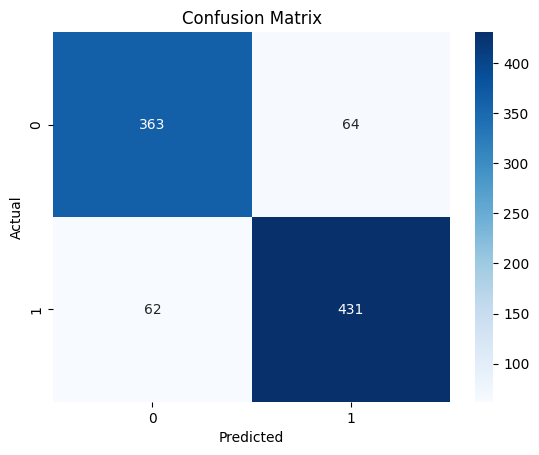

In [29]:
# Step 7: Confusion Matrix
def print_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("\n[CONFUSION MATRIX]:\n", cm)
    print("\n[CLASSIFICATION REPORT]:")
    print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

print_confusion(y_true, y_pred)

In [41]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Import the Model class definition from earlier in your notebook
# Make sure the Model class is defined before this cell runs
# from your_model_file import Model # If your model is in a separate file

# === 1. 설정 ===
validation_root = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/validation'  # 여기를 실제 경로로 수정
frames_required = 100
label_map = {'real': 0, 'fake': 1}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. 영상에서 일정 수의 프레임 추출 함수 ===
def extract_frames_from_video(video_path, num_frames=100):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    frames = []
    for idx in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if idx in frame_idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    return frames

# === 3. Transform 정의 ===
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === 4. Dataset 정의 ===
class ValidationVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, frames_required=100):
        self.samples = []
        self.transform = transform
        self.frames_required = frames_required

        for label_name in ['real', 'fake']:
            class_dir = os.path.join(root_dir, label_name)
            if not os.path.isdir(class_dir):
                print(f"[Warning] Directory not found: {class_dir}")
                continue
            for filename in os.listdir(class_dir):
                if filename.endswith('.mp4'):
                    self.samples.append((os.path.join(class_dir, filename), label_map[label_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = extract_frames_from_video(video_path, self.frames_required)

        if not frames:
            # Handle case where no frames are extracted
            print(f"[Warning] No frames extracted from {video_path}. Skipping.")
            # You might want to return None and handle it in the DataLoader loop,
            # or return a dummy tensor/skip the sample during dataset creation.
            # For simplicity here, we raise an error, but a more robust approach
            # would be to filter out invalid videos during dataset initialization.
            raise RuntimeError(f"No frames extracted from video: {video_path}")


        # transform each frame
        transformed_frames = [self.transform(frame) for frame in frames]
        frames_tensor = torch.stack(transformed_frames)  # Shape: [T, C, H, W]
        return frames_tensor, label

# === 5. 모델 불러오기 ===
# Instantiate the model with the same architecture as the saved checkpoint
# Ensure the Model class is defined in your notebook or imported
model = Model().to(device) # Create an instance of your Model class

# Load the checkpoint dictionary
checkpoint = torch.load('/content/drive/MyDrive/class/capstone_com/datasetbackup/checkpoints/best_checkpoint_DFDC.pth', map_location=device)

# Load the state_dict from the checkpoint into the model instance
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# === 6. DataLoader 만들기 ===
val_dataset = ValidationVideoDataset(validation_root, transform=transform, frames_required=frames_required)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# === 7. 평가 ===
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        # Ensure inputs have the correct shape for the model (B, T, C, H, W)
        # DataLoader with batch_size=1 will have shape [1, T, C, H, W] which is correct
        inputs = inputs.to(device)

        # Labels from Dataset might be a list/int, ensure it's a tensor
        labels = torch.tensor([labels]).to(device) # Wrap labels in a list if batch_size=1

        outputs = model(inputs)  # outputs shape: [1, 2]
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy()) # Extract scalar if batch_size=1

# === 8. 결과 출력 ===
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['real', 'fake']))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 208/208 [02:37<00:00,  1.32it/s]

Accuracy: 0.4855769230769231
Classification Report:
              precision    recall  f1-score   support

        real       0.67      0.02      0.04       108
        fake       0.48      0.99      0.65       100

    accuracy                           0.49       208
   macro avg       0.57      0.50      0.34       208
weighted avg       0.58      0.49      0.33       208



In [31]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
# Make sure the Model class is defined before this cell runs
from torch import nn
from torchvision import models

# Import the Model class definition from earlier in your notebook
class Model(nn.Module):
    def __init__(self, num_classes=2, latent_dim=1280, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.features = base.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        # Expected input shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.features(x)
        x = self.avgpool(x).view(B, T, -1)
        x, _ = self.lstm(x)
        out = self.fc(self.dropout(x.mean(dim=1)))
        return out


# === 1. 설정 ===
validation_root = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/validation'  # 여기를 실제 경로로 수정
frames_required = 100
label_map = {'real': 1, 'fake': 0} # Ensure label map matches your metadata (fake=0, real=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. 영상에서 일정 수의 프레임 추출 함수 ===
def extract_frames_from_video(video_path, num_frames=100):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Handle videos with fewer frames than required
    if total_frames < num_frames:
        print(f"[Warning] Video {video_path} has only {total_frames} frames, less than required {num_frames}. Skipping or padding might be needed.")
        return [] # Return empty list if not enough frames

    frame_idxs = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    frames = []
    for idx in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if idx in frame_idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

    cap.release()
    # Ensure exactly num_frames are returned, pad if necessary (or filter out small videos earlier)
    # For simplicity, if we didn't get enough frames here, we return less.
    # A more robust dataset might filter out videos with < frames_required.
    return frames


# === 3. Transform 정의 ===
# Ensure transform matches training if possible, or is appropriate for inference
im_size = 112 # Using the size defined in the training part
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)), # Use consistent size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Use consistent normalization
                         std=[0.229, 0.224, 0.225])
])


# === 4. Dataset 정의 ===
class ValidationVideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, frames_required=100):
        self.samples = []
        self.transform = transform
        self.frames_required = frames_required

        print(f"[INFO] Scanning directory: {root_dir}")
        for label_name in ['real', 'fake']:
            class_dir = os.path.join(root_dir, label_name)
            if not os.path.isdir(class_dir):
                print(f"[Warning] Directory not found: {class_dir}")
                continue
            print(f"[INFO] Scanning directory: {class_dir}")
            for filename in os.listdir(class_dir):
                if filename.endswith('.mp4'):
                    video_path = os.path.join(class_dir, filename)
                    # Optional: Add a check here if the video can be opened and has enough frames
                    # before adding it to samples. This makes the dataset more robust.
                    # For now, we rely on extract_frames_from_video to return [].
                    self.samples.append((video_path, label_map[label_name]))
        print(f"[INFO] Found {len(self.samples)} potential videos in validation set.")


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = extract_frames_from_video(video_path, self.frames_required)

        if not frames or len(frames) < self.frames_required:
             # Filter out videos with insufficient frames
            # print(f"[Warning] Insufficient frames ({len(frames)}) extracted from {video_path}. Required {self.frames_required}.")
            # This case should ideally be handled during dataset initialization
            # by not including such videos in self.samples.
            # If this still happens here, it means extract_frames_from_video
            # returned fewer frames than requested without explicit filtering in __init__.
            # A simple way to handle this in __getitem__ for training/validation
            # is to return None and handle it in the DataLoader's collate_fn,
            # or raise an error if you expect all samples to be valid.
            # For evaluation, skipping is often the best approach.
            # If we reach here, it's likely a video listed in self.samples failed.
            # Returning dummy data or raising an error are options.
            # Let's try raising an error to debug which video failed.
            raise RuntimeError(f"Failed to extract required {self.frames_required} frames from {video_path}. Got {len(frames)}.")


        # transform each frame
        transformed_frames = [self.transform(frame) for frame in frames]
        # Stack should be done after ensuring all frames are valid tensors
        try:
            frames_tensor = torch.stack(transformed_frames)  # Shape: [T, C, H, W]
        except Exception as e:
             raise RuntimeError(f"Error stacking frames from {video_path}: {e}") from e

        return frames_tensor, label

# === 5. 모델 불러오기 ===
# Instantiate the model with the same architecture as the saved checkpoint
# Ensure the Model class is defined in your notebook or imported
model = Model().to(device) # Create an instance of your Model class

# Load the checkpoint dictionary
checkpoint_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/checkpoints/best_checkpoint_DFDC.pth'
if not os.path.exists(checkpoint_path):
     raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the state_dict from the checkpoint into the model instance
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# === 6. DataLoader 만들기 ===
# Use a smaller batch size or adjust num_workers if you face memory issues
val_dataset = ValidationVideoDataset(validation_root, transform=transform, frames_required=frames_required)

# Check if the dataset is empty
if len(val_dataset) == 0:
    print("[ERROR] Validation dataset is empty. No videos found or processed.")
    # Exit or handle the case where no data is available for evaluation
else:
    print(f"[INFO] Created validation dataset with {len(val_dataset)} samples.")
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) # Batch size 1 for simplicity in evaluation

    # === 7. 평가 ===
    all_preds = []
    all_labels = []

    with torch.no_grad():
        # Add tqdm to the DataLoader loop to see progress
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            # Ensure inputs have the correct shape for the model (B, T, C, H, W)
            # DataLoader with batch_size=1 will have shape [1, T, C, H, W] which is correct
            inputs = inputs.to(device)

            # Labels from Dataset might be a list/int, ensure it's a tensor
            # If batch_size > 1, labels will already be a tensor
            if isinstance(labels, int): # Handle batch_size=1 case
                 labels = torch.tensor([labels]).to(device)
            else: # Handle batch_size > 1 case
                 labels = labels.to(device)


            outputs = model(inputs)  # outputs shape: [B, 2]
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy()) # Extract scalar if batch_size=1


    # === 8. 결과 출력 ===
    # Check if lists were populated before trying to print the report
    if not all_labels or not all_preds:
         print("[ERROR] No predictions were generated. Evaluation loop did not run or failed.")
    else:
        print("Accuracy:", accuracy_score(all_labels, all_preds))
        print("Classification Report:")
        # Ensure target_names match the labels found in the dataset (0 and 1)
        # If your labels are only 0s or only 1s, you might need to specify 'labels'
        # explicitly in classification_report, e.g., labels=[0, 1].
        print(classification_report(all_labels, all_preds, target_names=['fake', 'real'])) # Corrected target_names order to match label_map

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Scanning directory: /content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/validation
[Warning] Directory not found: /content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/validation/real
[Warning] Directory not found: /content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/validation/fake
[INFO] Found 0 potential videos in validation set.
[ERROR] Validation dataset is empty. No videos found or processed.


In [40]:
import os
import shutil
import pandas as pd

# 경로 설정
validation_dir = '/content/drive/MyDrive/class/capstone_com/datasetbackup/DFDC/validation'  # validation 폴더
metadata_path = '/content/drive/MyDrive/class/capstone_com/datasetbackup/metadata_DFDC.csv'  # 실제 CSV 경로를 여기에 입력

# 대상 폴더 만들기
real_dir = os.path.join(validation_dir, 'real')
fake_dir = os.path.join(validation_dir, 'fake')
os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_dir, exist_ok=True)

# 메타데이터 불러오기 (탭 구분자로 가정)
df = pd.read_csv(metadata_path, sep='\t')

# 각 파일을 라벨에 따라 이동
for _, row in df.iterrows():
    # 파일 경로에서 이름만 추출
    full_path = row['file']
    label = row['label'].strip().lower()  # 'real' 또는 'fake'

    filename = os.path.basename(full_path)  # 예: 'vpmyeepbep.mp4'
    src_path = os.path.join(validation_dir, filename)

    if not os.path.exists(src_path):
        print(f"❗ 파일 없음: {filename}")
        continue

    # 이동 대상
    dst_dir = real_dir if label == 'real' else fake_dir
    shutil.move(src_path, os.path.join(dst_dir, filename))
    print(f"✅ {filename} → {label} 폴더로 이동")


❗ 파일 없음: vpmyeepbep.mp4
❗ 파일 없음: jyxdpfccde.mp4
❗ 파일 없음: ifvpemzpuf.mp4
❗ 파일 없음: rrwdacnzcd.mp4
❗ 파일 없음: ttxuegkaew.mp4
❗ 파일 없음: ybkqykotud.mp4
❗ 파일 없음: nfqpnrwvep.mp4
❗ 파일 없음: tgawasvbbr.mp4
❗ 파일 없음: olqshoikjs.mp4
❗ 파일 없음: rcqcattfsu.mp4
❗ 파일 없음: gbensgskzr.mp4
❗ 파일 없음: xppjhsqnnm.mp4
❗ 파일 없음: vzysajdfrb.mp4
❗ 파일 없음: ihgazewlbd.mp4
❗ 파일 없음: ifvbwbcnyj.mp4
❗ 파일 없음: locbjirkex.mp4
❗ 파일 없음: vokrpfjpeb.mp4
❗ 파일 없음: vdmyzrdarn.mp4
❗ 파일 없음: oikhytmnol.mp4
❗ 파일 없음: qabreprhxg.mp4
❗ 파일 없음: ekvvevzkyu.mp4
❗ 파일 없음: kqwflqwnfm.mp4
❗ 파일 없음: qyxlicusfv.mp4
❗ 파일 없음: elxlnjzmzi.mp4
❗ 파일 없음: bfajruognp.mp4
❗ 파일 없음: gwypcwesyg.mp4
❗ 파일 없음: wiaiztlfzg.mp4
❗ 파일 없음: nmkvlryswx.mp4
❗ 파일 없음: byahwgvhmf.mp4
❗ 파일 없음: cwbubjzysv.mp4
❗ 파일 없음: sqladvmecy.mp4
❗ 파일 없음: gfjqirgmlo.mp4
❗ 파일 없음: uugkcetjxj.mp4
❗ 파일 없음: ptchnzeeqc.mp4
❗ 파일 없음: wjhpisoeaj.mp4
❗ 파일 없음: ejwxolkwsr.mp4
❗ 파일 없음: asgfrovmom.mp4
❗ 파일 없음: wbvjhwxgfk.mp4
❗ 파일 없음: rlqbowounu.mp4
❗ 파일 없음: ctbonxvats.mp4
❗ 파일 없음: rcjyfjozsp.mp4
❗ 파일 없음: sjkigpo